In [1]:
#Requires to have geopandas installed
#Installation https://geopandas.org/getting_started/install.html

import matplotlib.pyplot as plt 
import geopandas as gpd
import geoplot
import pandas as pd
import fiona #;help(fiona.open)
import requests
from pandas.io.json import json_normalize # convert json into dataframe
#For OSM 
import pyrosm
from pyrosm import OSM, get_data

In [6]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#  Adding MENA to Africa

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#world

In [8]:
saudi = world.query('name == "Saudi Arabia"')
yemen = world.query('name == "Yemen"')
iraq = world.query('name == "Iraq"')
oman = world.query('name == "Oman"')
uae = world.query('name == "United Arab Emirates"')
jordan = world.query('name == "Jordan"')
palestine = world.query('name == "Palestine"')
israel = world.query('name == "Israel"')
qatar = world.query('name == "Qatar"')
kuwait = world.query('name == "Kuwait"')

mena = saudi.append(yemen).append(iraq).append(oman).append(uae).append(jordan).append(palestine).append(israel).append(qatar).append(kuwait)

In [9]:
africa = world.query('continent == "Africa"').append(mena)
#africa.head()

In [10]:
### Example plot https://geopandas.org/gallery/plotting_with_geoplot.html?highlight=africa

# #gdp_per_cap = world.gdp_md_est / world.pop_est
# ax = geoplot.cartogram(
#     africa, scale='pop_est', limits=(0.2, 1),
#     edgecolor='None', figsize=(7, 8)
# )
# geoplot.polyplot(africa, edgecolor='gray', ax=ax)

In [11]:
#ax = africa.plot(color="white", edgecolors="red",figsize=(10, 10))

# 3) Substations - Onsset - OSM

Install PYROSM to handle OSM data: https://pyrosm.readthedocs.io/en/latest/installation.html

data source http://download.geofabrik.de/  

data description: https://gep-onsset.readthedocs.io/en/latest/GIS%20data%20collection.html

### OSM content check

In [63]:
from pyrosm import OSM, get_data

# Initialize the OSM reader with test data
fp = get_data("Helsinki")
osm = OSM(fp)

# The instance has a configuration attribute containing:
print([item for item in osm.conf.__dict__.keys() if not item.startswith("_")])


['network_filters', 'tags', 'oneway_values']


In [64]:
# Show all available tag attributes
#osm.conf.tags.available


In [65]:
# Show all tags that are converted into columns from building features
osm.conf.tags.power

['cable',
 'catenary_mast',
 'compensator',
 'converter',
 'generator',
 'heliostat',
 'insulator',
 'line',
 'busbar',
 'bay',
 'minor_line',
 'plant',
 'pole',
 'portal',
 'power',
 'substation',
 'switch',
 'switchgear',
 'terminal',
 'tower',
 'transformer']

## Create OSM substation dataframe

Pyrosm has an existing issue handling geofabric data. Thats why "get_data("africa")" is not working. 

A way around this problem is to download the data from http://download.geofabrik.de/africa-latest.osm.bz2 locally & set the path right

://github.com/HTenkanen/pyrosm/issues/109

In [66]:
pwd

'/home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/Data'

In [67]:
cd

/home/max


In [68]:
cd "OneDrive/PHD-Flexibility/07_pypsa-africa/Data"

/home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/Data


In [69]:
africa_data = "africa-latest.osm.pbf"

In [70]:
#Possible input to extract data from PYROSM. I.e. get_data("angola") gets the "angola-latest.osm.pbf" filled with all OSM data
regions =     ["algeria",
               "angola",
               "benin",
               "botswana",
               "burkina_faso",
               "burundi",
               "cameroon",
               "canary_islands",
               "cape_verde",
               "central_african_republic",
               "chad",
               "comores",
               "congo_brazzaville",
               "congo_democratic_republic",
               "djibouti",
               "egypt",
               "equatorial_guinea",
               "eritrea",
               "ethiopia",
               "gabon",
               "ghana",
               "guinea_bissau",
               "guinea",
               "ivory_coast",
               "kenya",
               "lesotho",
               "liberia",
               "libya",
               "madagascar",
               "malawi",
               "mali",
               "mauritania",
               "mauritius",
               "morocco",
               "mozambique",
               "namibia",
               "niger",
               "nigeria",
               "rwanda",
               "saint_helena_ascension_and_tristan_da_cunha",
               "sao_tome_and_principe",
               "senegal_and_gambia",
               "seychelles",
               "sierra_leone",
               "somalia",
               "south_africa_and_lesotho",
               "south_africa",
               "south_sudan",
               "sudan",
               "swaziland",
               "tanzania",
               "togo",
               "tunisia",
               "uganda",
               "zambia",
               "zimbabwe"]

In [2]:
fp = get_data("south_africa")

Downloaded Protobuf data 'south-africa-latest.osm.pbf' (238.9 MB) to:
'/tmp/pyrosm/south-africa-latest.osm.pbf'


In [3]:
fp

'/tmp/pyrosm/south-africa-latest.osm.pbf'

In [4]:
osm = pyrosm.OSM(fp)

In [5]:
my_filter = {'power': ["substation"]}

In [6]:
lesotho = osm.get_pois(custom_filter=my_filter)

In [12]:
lesotho.shape

(2576, 12)

In [14]:
lesotho.to_csv('south_africa.csv',index=False)

In [8]:
#Shows geometry reference
lesotho['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
#Converting Polygons to "centroids" = Points. 

#We used "epsg=3035" to make the long/lat numbers larger.
#This was necessary to make the centroid operations more accurate. Only required for small polygons.
#Afterward we reconvert it to the standard epsg=4326

lesotho['geometry'] = lesotho['geometry'].to_crs(epsg=3035)
lesotho['geometry'] = lesotho['geometry'].centroid
lesotho['geometry'] = lesotho['geometry'].to_crs(epsg=4326)

In [29]:
lesotho.head()

,changeset,id,version,lat,lon,tags,timestamp,power,substation,geometry,osm_type,transformer
0,0.0,366011186,8,-34.123283,18.400650,None,1608219802,substation,None,POINT (18.40065 -34.12328),node,NaN
1,0.0,533082726,2,-29.861341,30.881134,"{""location"":""outdoor""}",1478071001,substation,distribution,POINT (30.88113 -29.86134),node,NaN
2,0.0,565348680,7,-33.941769,18.426252,"{""name"":""Disa Park 144"",""man_made"":""street_cab...",1562352117,substation,distribution,POINT (18.42625 -33.94177),node,NaN
3,0.0,626585467,4,-25.440533,30.965998,"{""source"":""extrapolation"",""location"":""kiosk""}",1482396690,substation,distribution,POINT (30.96600 -25.44053),node,NaN
4,0.0,869344733,4,-25.493366,31.525007,"{""location"":""indoor""}",1482396690,substation,distribution,POINT (31.52501 -25.49337),node,NaN


In [21]:
df = lesotho.loc[lesotho['substation'] == 'transmission']

In [28]:
df.head()

,changeset,id,version,lat,lon,tags,timestamp,power,substation,geometry,osm_type,transformer
61,0.0,7248707972,1,-27.963926,25.039686,"{""operator"":""ESKOM""}",1582842633,substation,transmission,POINT (25.03969 -27.96393),node,NaN
65,NaN,28088740,7,NaN,NaN,"{""name"":""Croydon Substation"",""source"":""Yahoo"",...",1479999262,substation,transmission,POINT (28.19482 -26.14049),way,None
67,NaN,30878888,2,NaN,NaN,"{""voltage"":""132000"",""location"":""outdoor""}",1479411043,substation,transmission,POINT (25.52501 -33.97705),way,None
68,NaN,32509808,5,NaN,NaN,"{""ref"":""LEP"",""name"":""Lepini Substation"",""acces...",1479738279,substation,transmission,POINT (28.17954 -26.03229),way,None
72,NaN,42209493,8,NaN,NaN,"{""name"":""Prospect Substation"",""access"":""no"",""s...",1550871901,substation,transmission,POINT (28.09518 -26.22345),way,None


In [27]:
df.loc[lesotho['tags'] == ]

,changeset,id,version,lat,lon,tags,timestamp,power,substation,geometry,osm_type,transformer


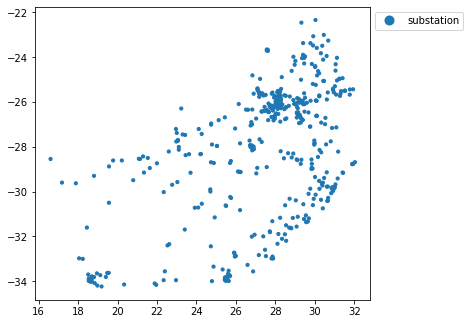

In [23]:
# Plot
ax = df.plot(column='power', marker='o', markersize=10, figsize=(6,6), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))

NameError: name 'africa' is not defined

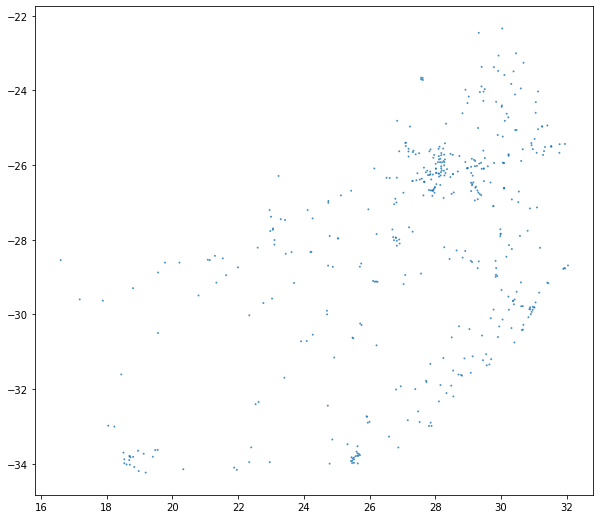

In [25]:
#Worked! Lesotho is down in South Africa
ax = df.plot(column='power',figsize=(10, 10),alpha = 0.7, markersize = 1)
geoplot.polyplot(africa, edgecolor='gray', ax=ax)